In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing as pp
import time

In [ ]:
cats = [
    'rec.autos',
    'rec.motorcycles',
    'sci.crypt',
    'sci.med'
]

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
newsgroups = fetch_20newsgroups(categories=cats, remove=('headers', 'footers', 'quotes'), subset = 'test')

In [ ]:
import nltk
nltk.download('all')

In [ ]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokenized = word_tokenize(text)
    porter = PorterStemmer()
    text = ' '.join([porter.stem(word) for word in tokenized])
    return text

docs = [preprocess(text) for text in newsgroups.data]

In [ ]:
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(docs)]
model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20)
document_vectors = [model.infer_vector(text.split()) for text in docs]

In [ ]:
import pandas as pd
doc_names = ['Doc {}'.format(i) for i in range(len(docs))]
lables = [cats[lab] for lab in list(newsgroups.target)]
df = pd.DataFrame()
df['Docs'] = doc_names
df['vec'] = document_vectors
df['lables'] = lables
df['numLables'] = newsgroups.target

In [ ]:
df

,Docs,vec,lables,numLables
0,Doc 0,"[0.3321275, -0.20328228, 0.15996918, 0.3872824...",sci.med,3
1,Doc 1,"[0.09581663, 0.257379, -0.046075363, 0.2123379...",rec.motorcycles,1
2,Doc 2,"[-0.28955176, -0.22223976, -0.06198772, 0.2025...",rec.motorcycles,1
3,Doc 3,"[-0.1525231, -0.2749216, 0.6626715, 0.91877323...",sci.crypt,2
4,Doc 4,"[0.07545908, 0.10871539, -0.0090087, -0.034643...",sci.med,3
...,...,...,...,...
1581,Doc 1581,"[-0.69364095, 0.105047256, -1.1240759, 0.51213...",rec.autos,0
1582,Doc 1582,"[-0.121873416, 0.012799775, 0.068644635, 0.163...",sci.crypt,2
1583,Doc 1583,"[-0.53547794, 0.11141133, -0.38802582, 0.63433...",rec.autos,0
1584,Doc 1584,"[0.06500297, 0.06849554, 0.086923674, 0.172664...",rec.motorcycles,1


In [ ]:
sdpDict = dict()
tsallisDict = dict()
renyiDict = dict()

In [ ]:
def getDissimMatrix(df) : 
  n = df.shape[0]
  res = np.zeros((n, n))
  for i in range(n) :
    for j in range(i + 1, n) : 
      res[i, j] = res[j, i] = 1 - getCosSim(df.iloc[i]['vec'], df.iloc[j]['vec'])
    # if i % 100 == 0 : print('Node', i, 'completed')
  return res

In [ ]:
def getCosSim(vec1, vec2) : 
  return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

In [ ]:
class BinaryQP(object) : 
    def __init__(self, adjacency) : 
        
        self.adj = adjacency
        self.n = len(self.adj)
        
        self.pot = np.array([0 for i in range(self.n)])
        self.constant = 0
        n = self.n
        
        cost_matrix = np.zeros((n+1, n+1))
        cost_matrix[np.ix_(list(range(n)),list(range(n)))] = self.adj
        cost_matrix[np.ix_([n],list(range(n)))] = [i/2 for i in self.pot]
        cost_matrix[np.ix_(list(range(n))),[n]] = [i/2 for i in self.pot]
        cost_matrix[n][n] = self.constant
        
        self.cost_matrix = cost_matrix
        
    def __str__(self) : 
        print("The Cost Matrix (S) is :")
        return str(self.cost_matrix)

In [ ]:
def solveUsingEPSDP(problem, Grad, rank,la, ga, steps):
    C = problem.cost_matrix
    D = np.diag(np.sum(C, axis=0))
    L = D - C
    C = L
    V = np.random.normal(0, 1, (rank, len(C)))
    V = np.transpose(pp.normalize(np.transpose(V), norm='l2'))
    step = 1/np.linalg.norm(C) 
    
    for outer_steps in range(10): 
        gradient = 2*np.matmul(V, C) - la*Grad(V)
        for s in range(steps):
            gradient = 2*np.matmul(V, C) - la*Grad(V)
            V = V + step*(gradient)
            V = np.transpose(pp.normalize(np.transpose(V), norm='l2'))
        la = la*ga
    U, s, Vt = np.linalg.svd(V)
    v1 = Vt.T[:, 0]
    return v1

def RenyiGrad(V):
    alpha = 4
    U1, d, U2 = np.linalg.svd(V, full_matrices=False)
    D = np.diag(d)
    R=U2.shape[1]
    I=np.identity(R, dtype="int")
    xa=(np.dot(U1, np.dot(np.linalg.matrix_power(D, 2*alpha-1),U2)))
    trxa=np.trace(np.linalg.matrix_power(D, 2*alpha))
    trx=np.trace(np.dot(D, D))
    x=np.dot(np.transpose(V),V)
    h=xa/trxa
    p=x/trx
    k = h @ (I-p) 
    return (alpha/(1-alpha))*k


def TsallisGrad(V):
    alpha = 4
    U1, d, U2 = np.linalg.svd(V, full_matrices=False)
    D = np.diag(d)    
    return (alpha/(1-alpha))*(np.dot(U1, np.dot(np.linalg.matrix_power(D, 2*alpha-1),U2))/np.power(np.trace(np.dot(D, D)), alpha) -  np.trace(np.linalg.matrix_power(D, 2*alpha))*V/np.power(np.trace(np.dot(D, D)), alpha+1) )

In [ ]:
class ClusterNode(object) :
  def __init__(self, items : list, level : int, config : list) : 
    self.items = items
    self.level = level
    self.config = config
    self.left = None
    self.right = None
  
  def __str__(self) : 
    res = 'items : ' + str(self.items) + '\n'
    res += 'level : ' + str(self.level) + '\n'
    res += 'config : ' + str(self.config) + '\n'
    return res

In [ ]:
max_clusters = 4

In [ ]:
def getWCSS(node : ClusterNode) : 
  items = node.items
  centroid = np.zeros(df.loc[0, 'vec'].shape[0])
  for item in items : 
    centroid += df.loc[item, 'vec']
  centroid = centroid / len(items)
  res = 0 
  for item in items : 
    res += np.linalg.norm(centroid - df.loc[item, 'vec'])
  return res 

## Tsallis Entropy

In [ ]:
def getLables(problem : BinaryQP, Grad = TsallisGrad) : 
  res = solveUsingEPSDP(problem, Grad, rank = 20, la = 10, ga = 5, steps = 100 )
  n = problem.n
  r = np.random.randn(n + 1)
  lables = list(np.sign(res))
  return lables

In [ ]:
from heapq import heappush, heappop
treeMemo = dict()
wcssMemo = dict()
def divisiveCluster(disMat_df, leafLength) -> ClusterNode : 
  n = disMat_df.shape[0]
  root = ClusterNode (
      items = list(range(n)),
      level = 0,
      config = []
  )

  q = [(0, root)]

  while len(q) <= max_clusters : 
    treeMemo[len(q)] = q.copy()
    # total_WCSS = sum([-(i* len(j.items)) for i, j in q])
    total_WCSS = sum([-i for i, j in q])
    wcssMemo[len(q)] = total_WCSS / len(q)
    _, currNode = q.pop(0)
    if len(currNode.items) < leafLength : continue
    # print('Cluster at level : ', currNode.level, 'is divided into ', end = " ")
    adj = getAdj(currNode.items, disMat_df)
    problem = BinaryQP(adj)
    lables = getLables(problem, TsallisGrad)
    pos =  []
    neg = []
    for item, lable in zip(currNode.items, lables) : 
      if lable > 0 : pos.append(item)
      else : neg.append(item)

    leftCluster = ClusterNode(items = neg, level = currNode.level + 1, config = currNode.config + [-1])
    rightCluster = ClusterNode(items = pos, level = currNode.level+ 1, config = currNode.config + [1] )
    currNode.left = leftCluster
    currNode.right = rightCluster 
    heappush(q, (-getWCSS(leftCluster), leftCluster))
    heappush(q, (-getWCSS(rightCluster), rightCluster))

    print('Cluster at level '+ str(currNode.level) +  ' with ' +  str(len(currNode.items)) + ' divided into ' + str( len(currNode.left.items))  +' and ' + str(len(currNode.right.items)) + ' nodes.'   )
    print(currNode)



  return root

In [ ]:
from collections import defaultdict
for nodes in range(5, 11) : 
  print('Stared ', nodes * 5, 'nodes : ', end = " ")
  dfMemo = defaultdict(lambda : set())
  for ind, record in df.iterrows() :
    if len(dfMemo[record['numLables']]) < nodes * 5 : 
      dfMemo[record['numLables']].add(ind)
  d = pd.DataFrame()
  for _, records in dfMemo.items() : 
    for record in records : 
      d = d.append(df.iloc[record], ignore_index = True)
  disMat = getDissimMatrix(d)
  disMat_df = pd.DataFrame(disMat, columns = d.index, index = d.index)
  problem = BinaryQP(disMat)
  n = disMat.shape[0]
  def getAdj(nodes, disMat_df) : 
    n = len(nodes)
    return disMat_df.iloc[nodes, nodes].to_numpy()
  start_time = time.time()


  rootCluster = divisiveCluster(disMat_df,20)
  clusters = treeMemo[4]
  memo = dict()
  for id, _ in enumerate(clusters) : 
    _, cluster = _
    for item in cluster.items : 
      memo[item] = id
  vals = sorted(memo.items())
  vals = [i for j, i in vals]
  d['pred'] = vals
  from collections import defaultdict
  jacScores = pd.DataFrame(np.zeros(36).reshape(6, 6))
  true_labels = d['numLables'].tolist()
  predicted_labels = d['pred'].tolist()

  truths = defaultdict(lambda : set())
  preds = defaultdict(lambda : set())

  for ind, label in enumerate(true_labels) :
      truths[label].add(ind)

  for ind, label in enumerate(predicted_labels) : 
      preds[label].add(ind)

  for t in range(4) : 
      for p in range(4) : 
          jacScores.iloc[t,p] = len(truths[t].intersection(preds[p])) 

  from heapq import heapify, heappush, heappop
  heap = [] #(val, ground, pred)
  for t in range(4) : 
      for p in range(4) : 
          heappush(heap, (-jacScores.iloc[t, p], t, p ))
  groundSeen = set()
  predSeen = set()
  mappedLabels = dict()
  while len(groundSeen) != 4 :
      _, t, p = heappop(heap)
      if t in groundSeen or p in predSeen : continue
      mappedLabels[p] = t
      groundSeen.add(t)
      predSeen.add(p)

  d['mapped'] = d['pred'].map(lambda x : mappedLabels[x])

  end_time = time.time()
  print(end_time - start_time)
  tsallisDict[nodes* 5 * 4 ] = end_time - start_time

Stared  25 nodes :  

<ipython-input-115-85d5cccf882c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 100 divided into 44 and 56 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
level : 0
config : []

Cluster at level 1 with 44 divided into 24 and 20 nodes.
items : [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 18, 20, 21, 22, 25, 30, 33, 40, 45, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 68, 69, 70, 72, 73, 74, 79, 87, 96]
level : 1
config : [-1]

Cluster at level 1 with 56 divided into 34 and 22 nodes.
items : [0, 9, 11, 17, 19, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 55, 64, 65, 66, 67, 71, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 9

<ipython-input-115-85d5cccf882c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 120 divided into 53 and 67 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
level : 0
config : []

Cluster at level 1 with 53 divided into 31 and 22 nodes.
items : [1, 2, 3, 4, 6, 7, 8, 9, 14, 15, 16, 17, 18, 20, 22, 23, 24, 27, 28, 29, 30, 35, 38, 45, 56, 57, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 94, 97, 100, 107, 116]
level : 1
config : [-1]

Cluster at level 1 with 67 divided into 32 and 35 nodes.
items : [0, 5, 10, 11, 12, 13, 19, 21, 25, 26, 31, 32, 33, 34, 36

<ipython-input-115-85d5cccf882c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 140 divided into 80 and 60 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
level : 0
config : []

Cluster at level 1 with 60 divided into 31 and 29 nodes.
items : [1, 2, 3, 4, 6, 9, 10, 13, 14, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29, 32, 33, 34, 35, 40, 43, 50, 61, 62, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 101, 102, 103, 104, 109, 112, 115, 127, 135, 136]
level : 1


<ipython-input-115-85d5cccf882c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 160 divided into 89 and 71 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
level : 0
config : []

Cluster at level 1 with 89 divided into 40 and 49 nodes.
items : [3, 4, 9, 10, 11, 14, 17, 18, 22, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 46, 47, 48, 50, 52, 53, 54, 56, 57, 59, 63, 67, 68, 69, 7

<ipython-input-115-85d5cccf882c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 180 divided into 112 and 68 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
level : 0
config : []

Cluster at level 1 with 112 divided into 65 and 47 nodes.
items : [0, 5, 7, 8, 11, 12, 15, 16, 19, 21, 23, 26, 28, 34, 

<ipython-input-115-85d5cccf882c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 200 divided into 75 and 125 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
level : 0
config : []

Cluster at level 1 

In [ ]:
tsallisDict

{100: 3.2163214683532715,
 120: 2.610410213470459,
 140: 2.7826590538024902,
 160: 2.8030662536621094,
 180: 3.0652103424072266,
 200: 3.41028094291687}

# RenyisEntropy

In [ ]:
from heapq import heappush, heappop
treeMemo = dict()
wcssMemo = dict()
def divisiveCluster(disMat_df, leafLength) -> ClusterNode : 
  n = disMat_df.shape[0]
  root = ClusterNode (
      items = list(range(n)),
      level = 0,
      config = []
  )

  q = [(0, root)]

  while len(q) <= max_clusters : 
    treeMemo[len(q)] = q.copy()
    # total_WCSS = sum([-(i* len(j.items)) for i, j in q])
    total_WCSS = sum([-i for i, j in q])
    wcssMemo[len(q)] = total_WCSS / len(q)
    _, currNode = q.pop(0)
    if len(currNode.items) < leafLength : continue
    # print('Cluster at level : ', currNode.level, 'is divided into ', end = " ")
    adj = getAdj(currNode.items, disMat_df)
    problem = BinaryQP(adj)
    lables = getLables(problem, RenyiGrad)
    pos =  []
    neg = []
    for item, lable in zip(currNode.items, lables) : 
      if lable > 0 : pos.append(item)
      else : neg.append(item)

    leftCluster = ClusterNode(items = neg, level = currNode.level + 1, config = currNode.config + [-1])
    rightCluster = ClusterNode(items = pos, level = currNode.level+ 1, config = currNode.config + [1] )
    currNode.left = leftCluster
    currNode.right = rightCluster 
    heappush(q, (-getWCSS(leftCluster), leftCluster))
    heappush(q, (-getWCSS(rightCluster), rightCluster))

    print('Cluster at level '+ str(currNode.level) +  ' with ' +  str(len(currNode.items)) + ' divided into ' + str( len(currNode.left.items))  +' and ' + str(len(currNode.right.items)) + ' nodes.'   )
    print(currNode)



  return root

In [ ]:
from collections import defaultdict
for nodes in range(5, 11) : 
  print('Stared ', nodes * 5, 'nodes : ', end = " ")
  dfMemo = defaultdict(lambda : set())
  for ind, record in df.iterrows() :
    if len(dfMemo[record['numLables']]) < nodes * 5 : 
      dfMemo[record['numLables']].add(ind)
  d = pd.DataFrame()
  for _, records in dfMemo.items() : 
    for record in records : 
      d = d.append(df.iloc[record], ignore_index = True)
  disMat = getDissimMatrix(d)
  disMat_df = pd.DataFrame(disMat, columns = d.index, index = d.index)
  problem = BinaryQP(disMat)
  n = disMat.shape[0]
  def getAdj(nodes, disMat_df) : 
    n = len(nodes)
    return disMat_df.iloc[nodes, nodes].to_numpy()
  start_time = time.time()


  rootCluster = divisiveCluster(disMat_df,20)
  clusters = treeMemo[4]
  memo = dict()
  for id, _ in enumerate(clusters) : 
    _, cluster = _
    for item in cluster.items : 
      memo[item] = id
  vals = sorted(memo.items())
  vals = [i for j, i in vals]
  d['pred'] = vals
  from collections import defaultdict
  jacScores = pd.DataFrame(np.zeros(36).reshape(6, 6))
  true_labels = d['numLables'].tolist()
  predicted_labels = d['pred'].tolist()

  truths = defaultdict(lambda : set())
  preds = defaultdict(lambda : set())

  for ind, label in enumerate(true_labels) :
      truths[label].add(ind)

  for ind, label in enumerate(predicted_labels) : 
      preds[label].add(ind)

  for t in range(4) : 
      for p in range(4) : 
          jacScores.iloc[t,p] = len(truths[t].intersection(preds[p])) 

  from heapq import heapify, heappush, heappop
  heap = [] #(val, ground, pred)
  for t in range(4) : 
      for p in range(4) : 
          heappush(heap, (-jacScores.iloc[t, p], t, p ))
  groundSeen = set()
  predSeen = set()
  mappedLabels = dict()
  while len(groundSeen) != 4 :
      _, t, p = heappop(heap)
      if t in groundSeen or p in predSeen : continue
      mappedLabels[p] = t
      groundSeen.add(t)
      predSeen.add(p)

  d['mapped'] = d['pred'].map(lambda x : mappedLabels[x])

  end_time = time.time()
  renyiDict[nodes* 5 * 4 ] = end_time - start_time

Stared  25 nodes :  

<ipython-input-118-419fc2a23cc4>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 100 divided into 52 and 48 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
level : 0
config : []

Cluster at level 1 with 48 divided into 24 and 24 nodes.
items : [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 18, 20, 21, 22, 25, 30, 33, 40, 45, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 72, 73, 74, 79, 87, 92, 95, 96]
level : 1
config : [1]

Cluster at level 1 with 52 divided into 28 and 24 nodes.
items : [0, 9, 11, 17, 19, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 55, 65, 66, 71, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90

<ipython-input-118-419fc2a23cc4>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 120 divided into 63 and 57 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
level : 0
config : []

Cluster at level 1 with 57 divided into 30 and 27 nodes.
items : [1, 2, 3, 4, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 22, 23, 24, 27, 28, 29, 30, 35, 38, 45, 56, 57, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 94, 97, 100, 107, 112, 115, 116]
level : 1
config : [1]

Cluster at level 1 with 63 divided into 29 and 34 nodes.
items : [0, 5, 11, 12, 13, 19, 21, 25, 26, 31, 3

<ipython-input-118-419fc2a23cc4>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 140 divided into 77 and 63 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
level : 0
config : []

Cluster at level 1 with 63 divided into 32 and 31 nodes.
items : [1, 2, 3, 4, 6, 7, 9, 10, 13, 14, 15, 19, 20, 21, 22, 23, 25, 27, 28, 29, 32, 33, 34, 35, 40, 43, 50, 61, 62, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 88, 89, 90, 92, 93, 94, 95, 96, 98, 101, 102, 103, 104, 106, 109, 112, 115, 121, 127, 135, 13

<ipython-input-118-419fc2a23cc4>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 160 divided into 72 and 88 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
level : 0
config : []

Cluster at level 1 with 88 divided into 48 and 40 nodes.
items : [5, 8, 11, 12, 16, 21, 29, 31, 35, 36, 41, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 

<ipython-input-118-419fc2a23cc4>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 180 divided into 99 and 81 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
level : 0
config : []

Cluster at level 1 with 99 divided into 52 and 47 nodes.
items : [0, 5, 7, 8, 11, 12, 16, 21, 23, 26, 28, 34, 36, 40, 41

<ipython-input-118-419fc2a23cc4>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 200 divided into 94 and 106 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
level : 0
config : []

Cluster at level 1 

In [ ]:
renyiDict

{100: 2.7480149269104004,
 120: 2.950413465499878,
 140: 3.134840488433838,
 160: 3.3593311309814453,
 180: 3.896790027618408,
 200: 5.8015336990356445}

## Using SDP

In [ ]:
!pip install cvxpy
import cvxpy as cp
def solveUsingSDP(problem : BinaryQP) : 
    C = problem.cost_matrix
    D = np.diag(np.sum(C, axis=0))
    L = D - C
    C = L
    n = len(C)
    t = 1e-4
    X = cp.Variable((n, n), symmetric = True)
    obj = cp.trace(C@X)
    constraints = [
        cp.diag(X) == 1
    ]
    constraints += [
        X - t*np.eye(n) >> 0
    ]
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(solver='SCS')
    L = np.linalg.cholesky(X.value)
    R = np.random.normal(size=(n,2))
    Xgw = np.dot(L, R)
    labels = np.sign(Xgw[:,0])
    return labels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def getLables(problem : BinaryQP) : 
  res = solveUsingSDP(problem)
  n = problem.n
  lables = list(np.sign(res))
  return lables

In [ ]:
def divisiveCluster(disMat_df, leafLength) -> ClusterNode : 
  n = disMat_df.shape[0]
  root = ClusterNode (
      items = list(range(n)),
      level = 0,
      config = []
  )

  q = [(0, root)]

  while len(q) <= max_clusters : 
    treeMemo[len(q)] = q.copy()
    # total_WCSS = sum([-(i* len(j.items)) for i, j in q])
    total_WCSS = sum([-i for i, j in q])
    wcssMemo[len(q)] = total_WCSS / len(q)
    _, currNode = q.pop(0)
    if len(currNode.items) < leafLength : continue
    # print('Cluster at level : ', currNode.level, 'is divided into ', end = " ")
    adj = getAdj(currNode.items, disMat_df)
    problem = BinaryQP(adj)
    lables = getLables(problem)
    pos =  []
    neg = []
    for item, lable in zip(currNode.items, lables) : 
      if lable > 0 : pos.append(item)
      else : neg.append(item)

    leftCluster = ClusterNode(items = neg, level = currNode.level + 1, config = currNode.config + [-1])
    rightCluster = ClusterNode(items = pos, level = currNode.level+ 1, config = currNode.config + [1] )
    currNode.left = leftCluster
    currNode.right = rightCluster 
    heappush(q, (-getWCSS(leftCluster), leftCluster))
    heappush(q, (-getWCSS(rightCluster), rightCluster))

    print('Cluster at level '+ str(currNode.level) +  ' with ' +  str(len(currNode.items)) + ' divided into ' + str( len(currNode.left.items))  +' and ' + str(len(currNode.right.items)) + ' nodes.'   )
    print(currNode)



  return root

In [ ]:
from collections import defaultdict
for nodes in range(5, 11) : 
  print('Stared ', nodes * 5, 'nodes : ', end = " ")
  dfMemo = defaultdict(lambda : set())
  for ind, record in df.iterrows() :
    if len(dfMemo[record['numLables']]) < nodes * 5 : 
      dfMemo[record['numLables']].add(ind)
  d = pd.DataFrame()
  for _, records in dfMemo.items() : 
    for record in records : 
      d = d.append(df.iloc[record], ignore_index = True)
  disMat = getDissimMatrix(d)
  disMat_df = pd.DataFrame(disMat, columns = d.index, index = d.index)
  problem = BinaryQP(disMat)
  n = disMat.shape[0]
  def getAdj(nodes, disMat_df) : 
    n = len(nodes)
    return disMat_df.iloc[nodes, nodes].to_numpy()
  start_time = time.time()


  rootCluster = divisiveCluster(disMat_df,20)
  clusters = treeMemo[4]
  memo = dict()
  for id, _ in enumerate(clusters) : 
    _, cluster = _
    for item in cluster.items : 
      memo[item] = id
  vals = sorted(memo.items())
  vals = [i for j, i in vals]
  d['pred'] = vals
  from collections import defaultdict
  jacScores = pd.DataFrame(np.zeros(36).reshape(6, 6))
  true_labels = d['numLables'].tolist()
  predicted_labels = d['pred'].tolist()

  truths = defaultdict(lambda : set())
  preds = defaultdict(lambda : set())

  for ind, label in enumerate(true_labels) :
      truths[label].add(ind)

  for ind, label in enumerate(predicted_labels) : 
      preds[label].add(ind)

  for t in range(4) : 
      for p in range(4) : 
          jacScores.iloc[t,p] = len(truths[t].intersection(preds[p])) 

  from heapq import heapify, heappush, heappop
  heap = [] #(val, ground, pred)
  for t in range(4) : 
      for p in range(4) : 
          heappush(heap, (-jacScores.iloc[t, p], t, p ))
  groundSeen = set()
  predSeen = set()
  mappedLabels = dict()
  while len(groundSeen) != 4 :
      _, t, p = heappop(heap)
      if t in groundSeen or p in predSeen : continue
      mappedLabels[p] = t
      groundSeen.add(t)
      predSeen.add(p)

  d['mapped'] = d['pred'].map(lambda x : mappedLabels[x])

  end_time = time.time()
  sdpDict[nodes* 5 * 4 ] = end_time - start_time

Stared  25 nodes :  

<ipython-input-123-49053c707bc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 100 divided into 47 and 53 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
level : 0
config : []

Cluster at level 1 with 47 divided into 24 and 23 nodes.
items : [1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 18, 20, 21, 22, 25, 30, 33, 40, 45, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 72, 73, 74, 79, 87, 92, 95, 96]
level : 1
config : [-1]

Cluster at level 1 with 53 divided into 27 and 26 nodes.
items : [0, 9, 10, 11, 17, 19, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 55, 65, 66, 71, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 88, 89, 9

<ipython-input-123-49053c707bc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 120 divided into 56 and 64 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
level : 0
config : []

Cluster at level 1 with 64 divided into 35 and 29 nodes.
items : [5, 12, 13, 20, 21, 26, 30, 31, 32, 33, 36, 37, 40, 41, 42, 44, 45, 47, 49, 51, 52, 53, 54, 55, 56, 57, 59, 60, 63, 64, 69, 70, 73, 75, 76, 77, 78, 79, 80, 81, 83, 84, 87, 88, 90, 91, 92, 94, 95, 96, 99, 102, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 117, 119]
level : 1
config : [1]

Cluster at level 1 with 56 divided into 28 and 28 nodes.
items

<ipython-input-123-49053c707bc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 140 divided into 67 and 73 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
level : 0
config : []

Cluster at level 1 with 73 divided into 36 and 37 nodes.
items : [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 32, 33, 34, 40, 43, 44, 48, 51, 53, 55, 58, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 91, 92, 93, 94, 95, 96, 99, 103, 10

<ipython-input-123-49053c707bc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 160 divided into 98 and 62 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
level : 0
config : []

Cluster at level 1 with 62 divided into 27 and 35 nodes.
items : [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 22, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 37, 38, 39, 40, 46, 47, 50, 55, 59, 68, 69, 73, 82

<ipython-input-123-49053c707bc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 180 divided into 81 and 99 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
level : 0
config : []

Cluster at level 1 with 99 divided into 46 and 53 nodes.
items : [5, 21, 28, 34, 36, 41, 45, 46, 47, 48, 49, 51, 52, 53,

<ipython-input-123-49053c707bc8>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = d.append(df.iloc[record], ignore_index = True)


Cluster at level 0 with 200 divided into 111 and 89 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
level : 0
config : []

Cluster at level 1 

In [ ]:
sdpDict

{100: 9.831706523895264,
 120: 22.02559471130371,
 140: 15.51340651512146,
 160: 91.09888768196106,
 180: 128.98459720611572,
 200: 121.09773278236389}

## Vislualizatoin

Text(0.5, 1.0, 'Running Times')

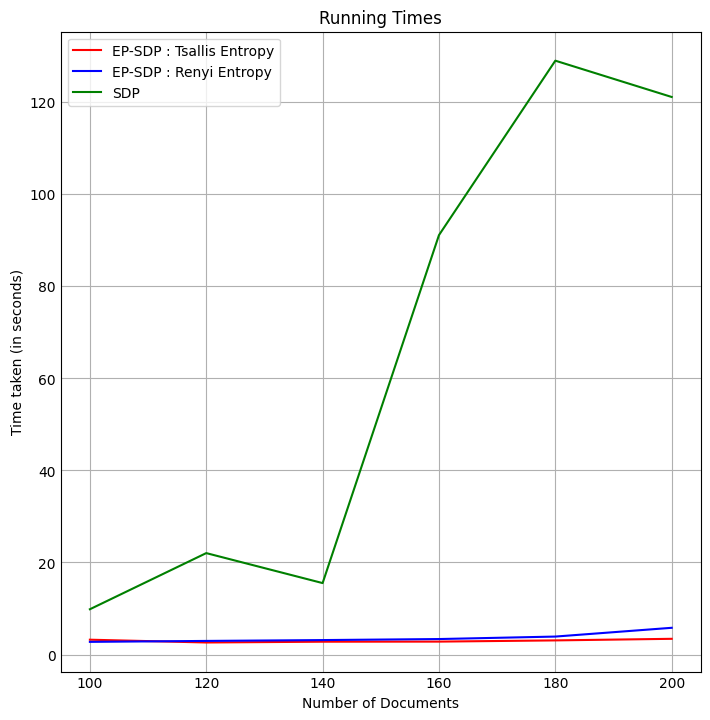

In [ ]:
fig = plt.figure(figsize=(8, 8))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(tsallisDict.keys(), tsallisDict.values(), 'r')
axes.plot(renyiDict.keys(), renyiDict.values(), 'b')
axes.plot(sdpDict.keys(), sdpDict.values(), 'g')
plt.legend(["EP-SDP : Tsallis Entropy", "EP-SDP : Renyi Entropy", 'SDP'])
axes.set_xlabel('Number of Documents')
axes.set_ylabel('Time taken (in seconds)')
axes.set_title('Running Times')